In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB0
from PIL import Image
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import Model
import random

In [2]:
data_dir = pathlib.Path("data/flower_photos")

print("✅ Dataset path:", data_dir.resolve())
print("Subfolders:", [f.name for f in data_dir.iterdir() if f.is_dir()])

image_count = len(list(data_dir.glob("**/*.jpg")))
print("Number of images:", image_count)

✅ Dataset path: C:\Users\ERICA\Documents\flower-classification\data\flower_photos
Subfolders: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
Number of images: 3670


First classes of the dataset:
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

Class distribution:
daisy: 633
dandelion: 898
roses: 641
sunflowers: 699
tulips: 799


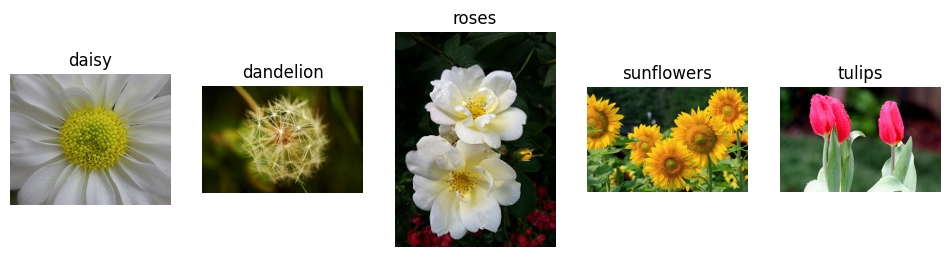

In [3]:
flower_names = sorted([f.name for f in data_dir.iterdir() if f.is_dir()])

print("First classes of the dataset:")
print(flower_names)

class_counts = {cls: len(list((data_dir / cls).glob("*.jpg"))) for cls in flower_names}
print("\nClass distribution:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")

plt.figure(figsize=(12, 6))
for i, cls in enumerate(flower_names[:5]): 
    img_path = list((data_dir / cls).glob("*.jpg"))[0]
    img = Image.open(img_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")
plt.show()

In [4]:
img_height = 180
img_width = 180
batch_size = 32

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names = train_ds.class_names
num_classes = len(class_names)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
base_model = EfficientNetB0(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = True
for layer in base_model.layers[:150]:  
    layer.trainable = False

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

In [8]:
inputs = keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.efficientnet.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

efficientnet_model = keras.Model(inputs, outputs)

In [9]:
efficientnet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [10]:
history = efficientnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)


Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 35s 259ms/step - accuracy: 0.7446 - loss: 0.6688 - val_accuracy: 0.9360 - val_loss: 0.2229
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 235ms/step - accuracy: 0.9511 - loss: 0.1480 - val_accuracy: 0.9046 - val_loss: 0.3460
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 242ms/step - accuracy: 0.9638 - loss: 0.1147 - val_accuracy: 0.9305 - val_loss: 0.2473
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 244ms/step - accuracy: 0.9836 - loss: 0.0560 - val_accuracy: 0.9319 - val_loss: 0.2790
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 235ms/step - accuracy: 0.9737 - loss: 0.0833 - val_accuracy: 0.9428 - val_loss: 0.2175
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 243ms/step - accuracy: 0.9866 - loss: 0.0446 - val_accuracy: 0.9251 - val_loss: 0.2836
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 233ms/step - accuracy: 0.9743 - loss: 0.0759 - val_accuracy: 0.9251 - val_loss: 0.3684
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 226ms/step - accuracy: 0.9809 - loss: 0.0519 - val_accu

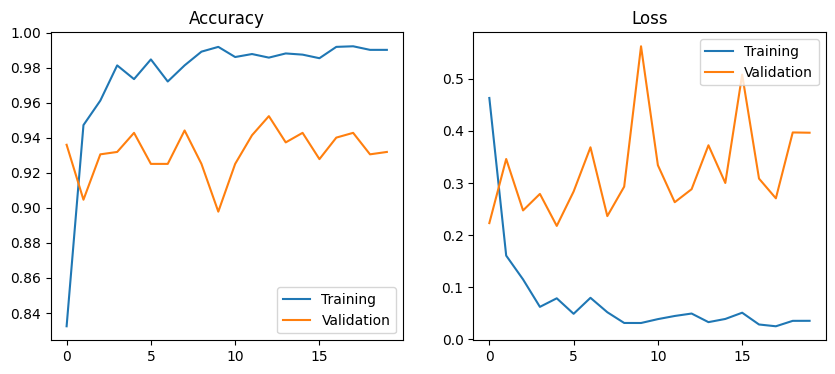

In [14]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs_range = range(len(acc))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training")
plt.plot(epochs_range, val_acc, label="Validation")
plt.legend(loc="lower right")
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training")
plt.plot(epochs_range, val_loss, label="Validation")
plt.legend(loc="upper right")
plt.title("Loss")
plt.show()

In [ ]:
os.makedirs("models", exist_ok=True)
efficientnet_model.save("models/flowers_efficientnetb0.keras")
print("Model saved at models/flowers_efficientnetb0.keras")

Model saved at models/flowers_efficientnetb0.keras


14600779226_7bbc288d40_m.jpg → True: daisy | Predicted: daisy (100.00%)
9111669902_9471c3a49c_n.jpg → True: dandelion | Predicted: dandelion (100.00%)
808239968_318722e4db.jpg → True: dandelion | Predicted: dandelion (99.98%)
8983779970_9d3a6a3bf2_n.jpg → True: daisy | Predicted: daisy (100.00%)
5607256228_2294c201b3.jpg → True: dandelion | Predicted: dandelion (100.00%)


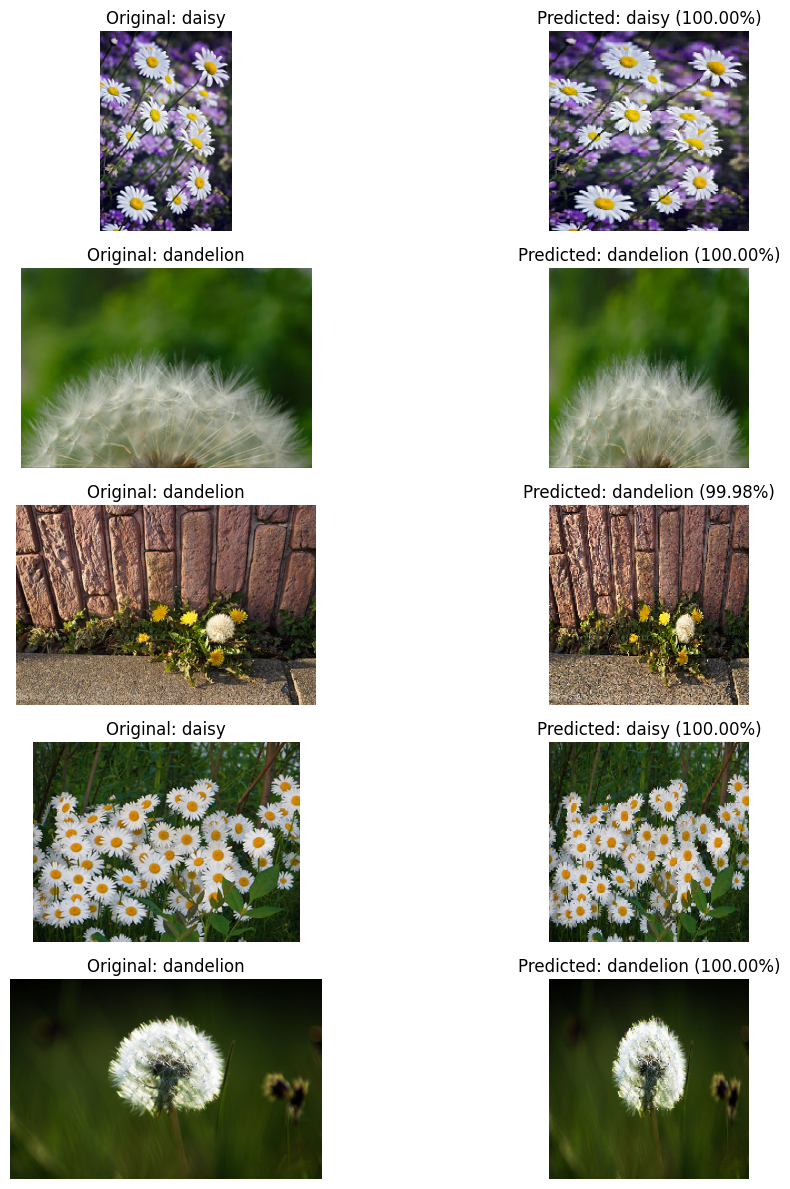

In [18]:
random.seed(123)

model = keras.models.load_model("models/flowers_efficientnetb0.keras")

all_paths = []
for cls in class_names:
    all_paths += list((data_dir / cls).glob("*.jpg"))
random.shuffle(all_paths)
img_paths = all_paths[:5]

imgs_resized, original_imgs, true_labels = [], [], []
for p in img_paths:
    true_labels.append(p.parent.name)
    original_imgs.append(Image.open(p))
    img = tf.keras.utils.load_img(p, target_size=(img_height, img_width))
    imgs_resized.append(tf.keras.utils.img_to_array(img))
batch = np.stack(imgs_resized, axis=0)

pred = model.predict(batch, verbose=0)
scores = pred if pred.ndim == 2 else pred[0]
pred_idx = np.argmax(pred, axis=1)
pred_classes = [class_names[i] for i in pred_idx]
conf = 100 * np.max(pred, axis=1)

plt.figure(figsize=(12, 12))
for i, (orig, tc, pc, cf, resized) in enumerate(zip(original_imgs, true_labels, pred_classes, conf, imgs_resized)):
    print(f"{img_paths[i].name} → True: {tc} | Predicted: {pc} ({cf:.2f}%)")
    plt.subplot(len(img_paths), 2, 2*i + 1)
    plt.imshow(orig)
    plt.title(f"Original: {tc}")
    plt.axis("off")
    plt.subplot(len(img_paths), 2, 2*i + 2)
    plt.imshow(resized.astype("uint8"))
    plt.title(f"Predicted: {pc} ({cf:.2f}%)")
    plt.axis("off")
plt.tight_layout()
plt.show()
